<a href="https://colab.research.google.com/github/LMAPcoder/Machine-Learning-Lab/blob/main/Exercise_sheet7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Lab Programming Machine Learning**

## Exercise Sheet 7

Introduction

Time series data is a collection of observations obtained through repeated measurements over time.

Time Series Classification is a problem where the overall goal is to identify a time series as coming from one of possibly many sources (classes), using labeled training data.

The UCR Time Series Archive is a repository of time series datasets from various domains, commonly used for benchmarking time series algorithms.

Each of the data sets comes in two parts, a TRAIN partition and a TEST partition. The first value in the row is the class label (an integer between 1 and the number of classes). The rest of the row are the data sample values.

### Exercise 0: Dataset Preprocessing

In [ ]:
import pandas as pd
import zipfile as zpf
import numpy as np
import scipy.spatial as spatial

In [ ]:
#Uploading the file
!wget --no-check-certificate 'https://www.cs.ucr.edu/~eamonn/time_series_data_2018/UCRArchive_2018.zip' -O UCRArchive_2018.zip

--2022-01-01 14:45:50--  https://www.cs.ucr.edu/~eamonn/time_series_data_2018/UCRArchive_2018.zip
Resolving www.cs.ucr.edu (www.cs.ucr.edu)... 169.235.30.15
Connecting to www.cs.ucr.edu (www.cs.ucr.edu)|169.235.30.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 316175400 (302M) [application/zip]
Saving to: ‘UCRArchive_2018.zip’

UCRArchive_2018.zip 100%[===================>] 301.53M  84.2MB/s    in 3.8s    

2022-01-01 14:45:54 (78.4 MB/s) - ‘UCRArchive_2018.zip’ saved [316175400/316175400]



In [ ]:
%%time
#Extration of datasets from UCRArchive_2018.zip
zip_file = zpf.ZipFile('UCRArchive_2018.zip')
dfs = {tsv_file.filename: pd.read_csv(zip_file.open(tsv_file.filename,pwd=b'someone'), sep='\t', header=None) #b'string' transform string into bytes
       for tsv_file in zip_file.infolist()
       if tsv_file.filename.endswith('.tsv')}
zip_file.close()

CPU times: user 8min 9s, sys: 1.98 s, total: 8min 11s
Wall time: 8min 35s


In [ ]:
#Creation of a dictionary with datasets names as keys and merged dataframes (TRAIN+TEST) as values
dfns = {}
for dfk in dfs.keys():
  if dfk.find('Missing_value_and_variable_length_datasets_adjusted') > -1:
    continue
  dot_p = dfk.rfind('.')
  uds_p = dfk.rfind('_')
  slh_p = dfk.rfind('/')
  dfn = dfk[slh_p+1:uds_p] #dataframe name
  if dfn in dfns.keys(): #check if the dataframe name is already a key of the dictionary
    dfns[dfn].append(dfk) #append a df path to the list
  else:
    dfns[dfn] = [dfk] #add a new key-value pair(key: df name, value: list[df path]
dfs_merged = {}
for dfn in dfns.keys():
  dfs_merged[dfn] = pd.concat([dfs[dfns[dfn][0]],dfs[dfns[dfn][1]]],ignore_index=True) #concatenate the dataframes in dfs within the lists

Data sets. Small description

In [ ]:
print('Number of datasets',len(dfs_merged))
statis = pd.DataFrame(0,index=dfs_merged.keys(),columns=['Times series length','Number of samples','Number of classes','Number of NaN'])
for dfk in dfs_merged.keys():
  df = dfs_merged[dfk]
  statis.at[dfk,'Times series length'] = len(df.columns-1)
  statis.at[dfk,'Number of samples'] = len(df)
  statis.at[dfk,'Number of classes'] = df[0].nunique()
  statis.at[dfk,'Number of NaN'] = df.isna().values.sum()
statis.sort_index()

Number of datasets 128


,Times series length,Number of samples,Number of classes,Number of NaN
ACSF1,1461,200,10,0
Adiac,177,781,37,0
AllGestureWiimoteX,501,1000,10,375263
AllGestureWiimoteY,501,1000,10,375263
AllGestureWiimoteZ,501,1000,10,375263
...,...,...,...,...
Wine,235,111,2,0
WordSynonyms,271,905,25,0
Worms,901,258,5,0
WormsTwoClass,901,258,2,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa906470450>,
      dtype=object)

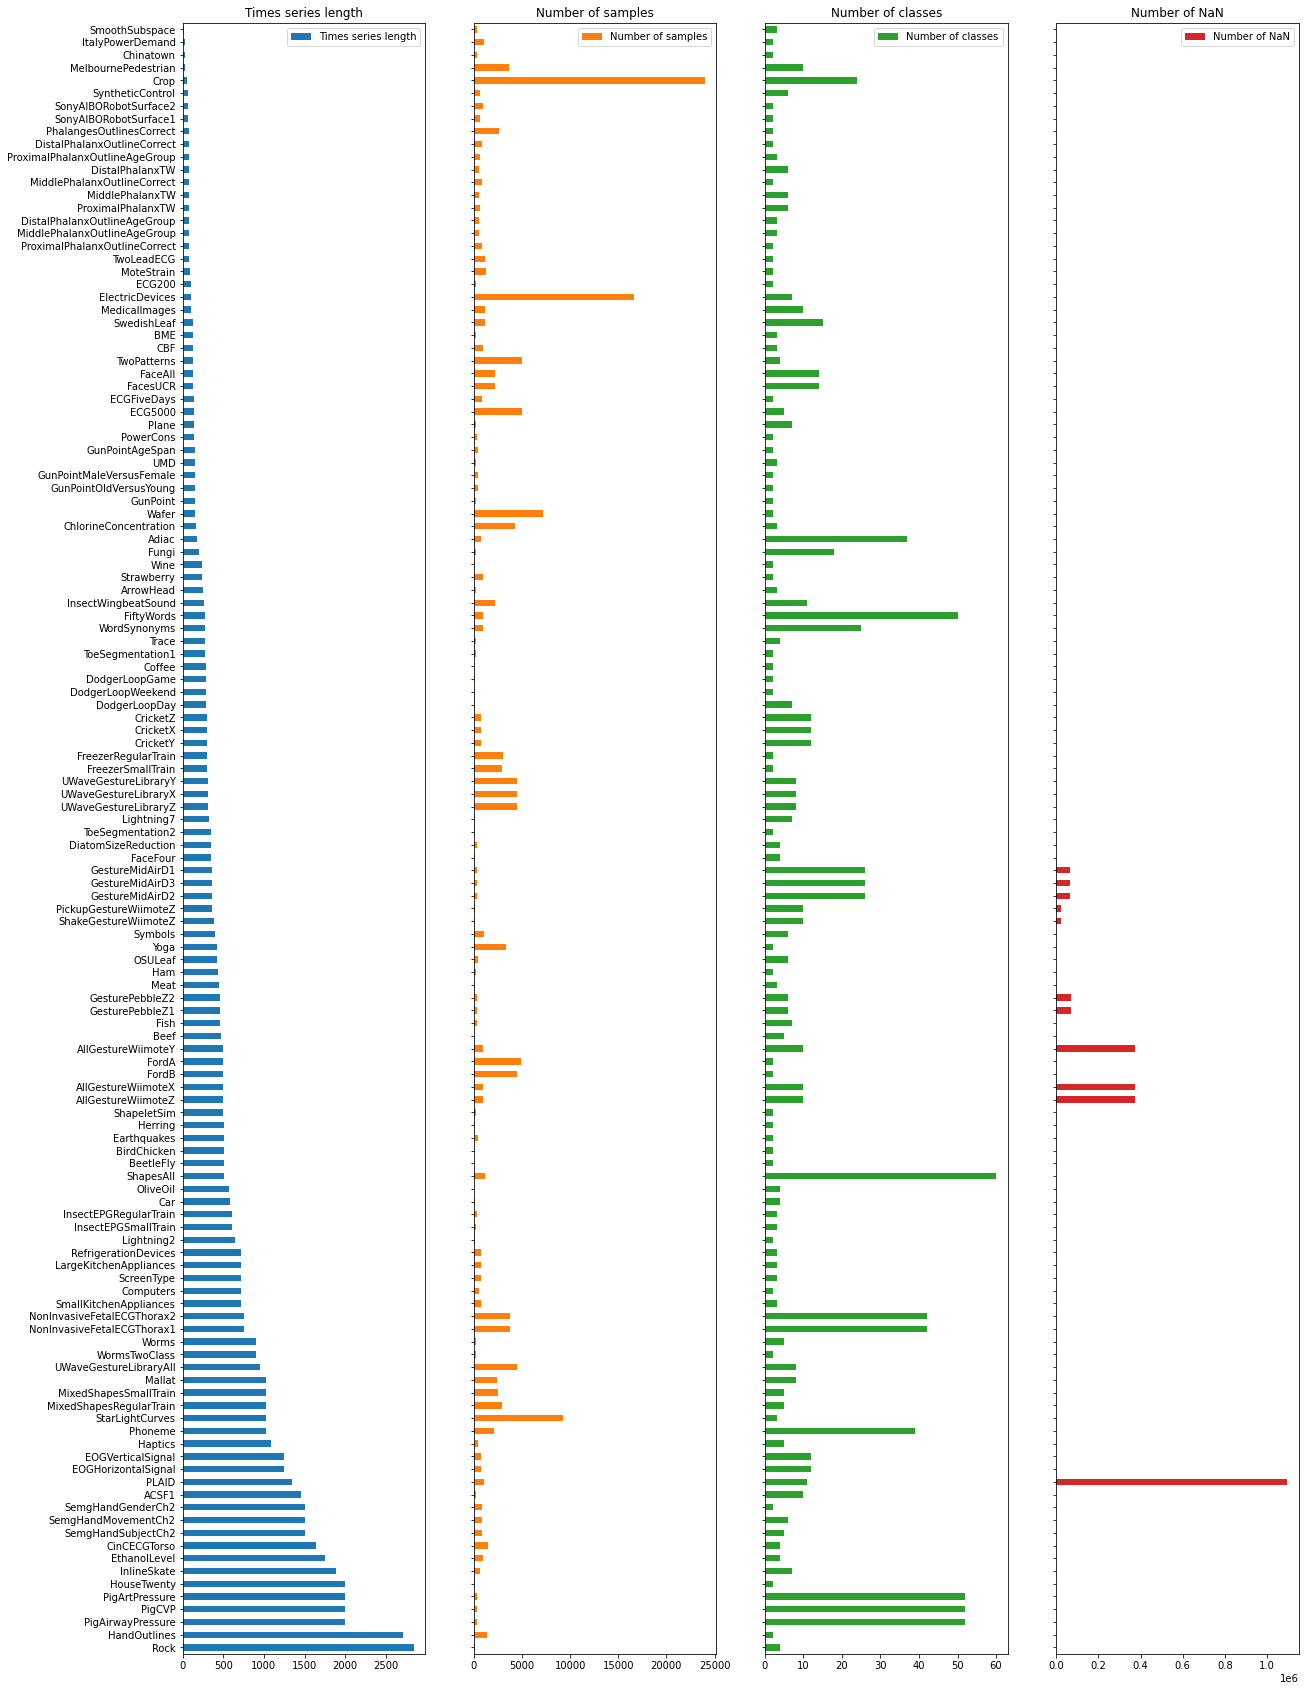

In [ ]:
statis.sort_values(by='Times series length',ascending=False).plot(kind='barh',figsize=(20,30),subplots=True,layout=(1,4),sharex=False,sharey=True)


Splitting the data

In [ ]:
# Input: dataframe, ratio of training data, ratio od validation data
# Output: 2-3 dataframes split accordingly
def data_partition(df,train_ratio,valid_ratio=None):
  N, M = df.shape
  df_sample = df.sample(frac=1,random_state=3116) #Return a random sample of items from an axis of object
  split1 = int(N*train_ratio)
  data_Train = df_sample[:split1]

  if valid_ratio is None:
    data_Test = df_sample[split1:]
    return data_Train,data_Test
  else:
    split2 = int(N*(train_ratio+valid_ratio))
    data_Valid = df_sample[split1:split2]
    data_Test = df_sample[split2:]
    return data_Train,data_Test,data_Valid

In [ ]:
#Split of each dataframe into train, validation and test datasets. The dictionaries that hold the datasets portions are the values of the main dictionary
dfs_resplit = {}
for dfk in dfs_merged.keys():
  resplit_data = data_partition(dfs_merged[dfk],0.7,0.15)
  dfs_resplit[dfk] = {'TRAIN':resplit_data[0],'TEST':resplit_data[1],'VALID':resplit_data[2]}

Standarization of the datasets

In [ ]:
#Standarization of each of the datasets. Separately
dfs_stand = {}
for dfn in dfs_resplit.keys():
  dfps = {}
  for dfp in dfs_resplit[dfn].keys():
    df = dfs_resplit[dfn][dfp].drop(0,axis=1)
    df = (df-df.mean())/df.std()
    df[0] = dfs_resplit[dfn][dfp][0]
    dfps[dfp] = df
  dfs_stand[dfn] = dfps

### Exercise 1: Dataset Imputation with KNN

Imputation is the process of replacing missing data with substituted values. Although there are many methods that can be used, the k-nearest neighbor (KNN) algorithm has proven to be generally effective.

List the datasets having missing values

In [ ]:
dfs_nan = {}
i = 0
for dfk in dfs_merged.keys():
  p_na = dfs_merged[dfk].isnull().values.any() #presence of missing values
  if p_na:
    dfs_nan[dfk] = dfs_merged[dfk]
    ts_length = len(dfs_merged[dfk].columns-1)
    n_samples = len(dfs_merged[dfk])
    n_na = dfs_merged[dfk].isnull().sum().sum()
    i += 1
    print(i,'Name',dfk,'; Time series length:',ts_length,'; Number of samples:',n_samples,'; Number of missing values:',n_na)

1 Name ShakeGestureWiimoteZ ; Time series length: 386 ; Number of samples: 100 ; Number of missing values: 21768
2 Name AllGestureWiimoteZ ; Time series length: 501 ; Number of samples: 1000 ; Number of missing values: 375263
3 Name PLAID ; Time series length: 1345 ; Number of samples: 1074 ; Number of missing values: 1094025
4 Name PickupGestureWiimoteZ ; Time series length: 362 ; Number of samples: 100 ; Number of missing values: 21529
5 Name MelbournePedestrian ; Time series length: 25 ; Number of samples: 3633 ; Number of missing values: 253
6 Name DodgerLoopWeekend ; Time series length: 289 ; Number of samples: 158 ; Number of missing values: 337
7 Name AllGestureWiimoteX ; Time series length: 501 ; Number of samples: 1000 ; Number of missing values: 375263
8 Name DodgerLoopGame ; Time series length: 289 ; Number of samples: 158 ; Number of missing values: 337
9 Name GesturePebbleZ1 ; Time series length: 456 ; Number of samples: 304 ; Number of missing values: 71655
10 Name Gestur

kNN imputation on datasets with missing values

In [ ]:
# Input: dataframe used as training dataset, instance (row), distance measure
# Output: numpy array of distances between the instance and each of the samples of the dataframe
def distance(df,instance,distype):
  distances = list()
  if distype == 'euclidean':
    for index, row in df.iterrows():
      d = (((instance-row)**2).sum())**(1/2)
      distances.append([index,d])
  else:
    for index, row in df.iterrows():
      d = spatial.distance.pdist([row,instance], metric=distype)[0]
      distances.append([index,d])
  return np.array(distances)

# Input: dataframe used as training dataset, instance (row), number for neighbors to take, distance measure
# Output: numpy array of size K with the indices of the k-nearest neighbors to the instance in the dataframe
def knns_v1(df,instance,k,distype): #set of k nearest rows of the dataframe to the instance
  D = distance(df,instance,distype)
  C_idxs = D[np.argsort(D[:,1])][:,0][:k].astype(int) #sorted array in ascending order
  return C_idxs

In [ ]:
# Input: dataframe used as training dataset, instance (row), distance measure
# Output: numpy array of distances between the instance and each of the samples of the dataframe

#This is a second version of the above algorithm that proved to be three times faster

def knns_v2(df,instance,K,distype):
  D = np.empty([K,2]) #initialization of distance array. It is a 2D array with indices and distances
  i = 0
  for index, row in df.iterrows():
    d = spatial.distance.pdist([row,instance], metric=distype)[0]
    if i <= K: #the first K distances are directly placed into the distance array
      if i < K:
        D[i] = [index,d]
        i += 1
        continue
      else:
        D = D[np.argsort(D[:,1])] #the first K distances are sorted
        DK = D[K-1,1]
        i += 1
    if d < DK: #the new calculated distances are compared only to the last and bigger value of the distance array
      D[K-1] = [index,d]
      D = D[np.argsort(D[:,1])] #when a new distance is added, the array is sorted again
      DK = D[K-1,1]
  C_idxs = D[:,0].astype(int)
  return C_idxs

In [ ]:
# Input: dataframe with missing values, distance measure
# Output: fixed dataframe with no missing values
def KNNImputator(df,k,distype='euclidean'):
  df_fixed = df.copy()
  for c in df.columns: #iterate through columns
    rs = df[df[c].isna()] #selecting the rows of dataframe with missing values in the column
    if len(rs) == 0:
      continue
    for index, row in rs.iterrows():
      na = row.isna() #boolean series identiying missing values within the row
      cwona = [i for i in na.index if na[i] == False] #columns where the row has no missing values
      #df[cwona] #sub dataframe with columns where the row has no missing values
      sdf = df[cwona][np.invert(df[cwona + [c]].isna().any(axis=1))] #sub dataframe with columns and rows with no missing values
      #row[cwona] #sub row with column with no missing values
      C_idxs = knns_v2(sdf,row[cwona],k,distype) #indeces of the k-nearest instances
      v = df.loc[C_idxs][c].sum()/k #predicted value for the missing value. Mean of the k-nearest instances
      df_fixed.at[index,c] = v
  return df_fixed

K-Nearest Neighbour classifier

In [ ]:
# Input: dataframe used as training dataset (df1), dataframe whose class we need to predict (df2), distance measure
# Output: dataframe with predicted class by k-nearest neighbors
def KNNClassifier_v1(df1,df2,k,distype='euclidean'): #Brute force classifier
  np.random.seed(3116)
  y_pred = pd.Series(index=df2.index,dtype=float) #class vector
  df1woc = df1.drop(0,axis=1) #class column is drop
  df2woc = df2.drop(0,axis=1) #class column is drop
  for index, row in df2woc.iterrows():
    C_idxs = knns_v2(df1woc,row,k,distype) #array of indices of the K-nearest neighbors to the instance of df2 (row)
    C = df1.loc[C_idxs]
    y_pred.loc[index] = np.random.choice(C[0].mode()) #when the series of classes is multimodal, the selection is random
  df2woc[0] = y_pred
  return df2woc

In [ ]:
#Classification Accuracy value
accuracy = lambda df1,df2: (df1[0] == df2[0]).mean()

Grid search

Warning: for this task I only used three datasets (the smallest ones) with missing values because of the limited computational capacity I have. Moreover, for imputation I used the whole datasets that I then split to perform the classification.

In [ ]:
%%time
K_imput = np.arange(1,5,1) #set of Ks (nearest-neighbors) used for imputation
K_class = np.arange(1,5,1) #set of Ks (nearest-neighbors) used for classification
datasets = ['DodgerLoopWeekend','DodgerLoopGame','DodgerLoopDay'] #datasets with missing values to use

acc_grid = pd.DataFrame(0,index=K_imput,columns=K_class,dtype=float) #accuracy grid
acc_grid.columns.name = 'K_i'
acc_grid.index.name = 'K_c'

dfs_nan_repaired = {}
for k_i in K_imput:
  
  #Imputation loop
  for dfk in datasets:
    dfs_nan_repaired[dfk] = KNNImputator(dfs_nan[dfk],k_i)
  
  #Resplit loop
  dfs_nan_resplit = {}
  for dfk in datasets:
    resplit_df = data_partition(dfs_nan_repaired[dfk],0.7,0.15)
    dfs_nan_resplit[dfk] = {'TRAIN':resplit_df[0],'TEST':resplit_df[1],'VALID':resplit_df[2]}

  #Classification loop
  for k_c in K_class:
    accuracies = list()
    for dfk in datasets:
      train_df = dfs_nan_resplit[dfk]['TRAIN']
      valid_df = dfs_nan_resplit[dfk]['VALID']
      pred_df = KNNClassifier_v1(train_df,valid_df,k_c)
      accuracy_df = accuracy(valid_df,pred_df)
      accuracies.append(accuracy_df)
    acc_grid.at[k_i,k_c] = np.mean(accuracies)

CPU times: user 2min 28s, sys: 1.05 s, total: 2min 30s
Wall time: 2min 39s


In [ ]:
acc_grid.style.background_gradient(cmap='Blues',axis=None)

K_i,1,2,3,4
K_c,,,,
1,0.805556,0.819444,0.847222,0.888889
2,0.805556,0.819444,0.847222,0.916667
3,0.805556,0.819444,0.847222,0.916667
4,0.805556,0.819444,0.847222,0.916667


Test accuracy

In [ ]:
#Computation of test accuracies on datasets using optimal found values of K
k_i_max = acc_grid.max(axis=0).idxmax() #optimal K found for imputation
k_c_max = acc_grid.max(axis=1).idxmax() #optmial K found for classification
print('Optimal K for imputation:',k_i_max,'Optimal K for classification:',k_c_max)

for dfk in datasets:
  df_nan_repaired = KNNImputator(dfs_nan[dfk],k_i)
  df_nan_resplit = data_partition(df_nan_repaired,0.7,0.15)
  train_df = df_nan_resplit[0]
  valid_df = df_nan_resplit[1]
  test_df = df_nan_resplit[2]
  tv_df = pd.concat([train_df,valid_df])
  pred_df = KNNClassifier_v1(tv_df,test_df,k_c)
  accuracy_df = accuracy(test_df,pred_df)
  print('Dataset:',dfk,'Test accuracy',accuracy_df)

Dataset: DodgerLoopWeekend Test accuracy 1.0
Dataset: DodgerLoopGame Test accuracy 0.9166666666666666
Dataset: DodgerLoopDay Test accuracy 0.6666666666666666


### Exercise 2: Time Series Classification with Various Distance Measures

Warning: for this task I only used a smaller number of datasets chosen randomly because of the limited computational capacity I have. Moreover, Mahalanobis, Yule and Kensenshannon distance measures were not used because they presented errors with my algorithm.

In [ ]:
%%time
K = np.arange(1,6,1) #set of Ks (nearest-neighbors) used
d_measures = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',\
              'cosine', 'dice', 'euclidean', 'hamming', 'jaccard',\
              'kulsinski', 'matching', 'minkowski', 'rogerstanimoto',\
              'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean'] #set of distances used

acc_grid = pd.DataFrame(0,index=d_measures,columns=K,dtype=float) #accuracy grid
acc_grid.columns.name = 'K'
acc_grid.index.name = 'd_measures'

datasets = ['Beef','BeetleFly','HouseTwenty','Haptics','Chinatown','GunPoint','Adiac','Fish',\
            'ArrowHead','Lightning2','Plane','Fungi','Meat','FaceFour','ACSF1'] #set of datasets used

for k in K:
  for dm in d_measures:
    accuracies = list()
    for dfk  in datasets:
      train_df = dfs_stand[dfk]['TRAIN']
      valid_df = dfs_stand[dfk]['VALID']
      pred_df = KNNClassifier_v1(train_df,valid_df,k,dm)
      accuracy_df = accuracy(valid_df,pred_df)
      accuracies.append(accuracy_df)
    acc_grid.at[dm,k] = np.mean(accuracies)

CPU times: user 36min 55s, sys: 14.3 s, total: 37min 10s
Wall time: 37min 29s


In [ ]:
acc_grid.style.background_gradient(cmap='Blues',axis=None)

K,1,2,3,4,5
d_measures,,,,,
braycurtis,0.830844,0.775894,0.787933,0.739993,0.763626
canberra,0.787943,0.744959,0.783881,0.764132,0.769985
chebyshev,0.704012,0.687573,0.669274,0.662227,0.670439
cityblock,0.785129,0.761007,0.800445,0.759582,0.784473
correlation,0.811358,0.759384,0.781777,0.737458,0.760206
cosine,0.800918,0.740248,0.771379,0.739171,0.750021
dice,0.258570,0.259608,0.263025,0.294029,0.295538
euclidean,0.805038,0.753697,0.803823,0.744614,0.753580
hamming,0.258570,0.259608,0.263025,0.294029,0.295538


Test accuracy

In [ ]:
#Computation of test accuracies on datasets using optimal found values of K and distance measure
K_max = acc_grid.max(axis=0).idxmax() #optimal K found
dm_max = acc_grid.max(axis=1).idxmax() #optmial measure distance found
print('Optimal K:',K_max,'Optimal distance measure:',dm_max)
for dfk in datasets:
  train_df = dfs_stand[dfk]['TRAIN']
  valid_df = dfs_stand[dfk]['VALID']
  test_df = dfs_stand[dfk]['TEST']
  tv_df = pd.concat([train_df,valid_df])
  pred_df = KNNClassifier_v1(tv_df,test_df,K_max,dm_max)
  accuracy_df = accuracy(test_df,pred_df)
  print(dfk,accuracy_df)

Optimal K: 1 Optimal distance measure: braycurtis
Beef 0.4444444444444444
BeetleFly 0.8333333333333334
HouseTwenty 0.8333333333333334
Haptics 0.4
Chinatown 0.9818181818181818
GunPoint 0.8333333333333334
Adiac 0.6440677966101694
Fish 0.8867924528301887
ArrowHead 0.84375
Lightning2 0.7894736842105263
Plane 0.96875
Fungi 0.967741935483871
Meat 1.0
FaceFour 1.0
ACSF1 0.6


Ranking of all distance metrics according to the test accuracy

In [ ]:
#Computation of test accuracies on datasets using optimal found value of K for each distance measure
acc_dist = pd.Series(0,index=d_measures,dtype=float)
for dm in d_measures:
  accuracies = list()
  for dfk in datasets:
    train_df = dfs_stand[dfk]['TRAIN']
    valid_df = dfs_stand[dfk]['VALID']
    test_df = dfs_stand[dfk]['TEST']
    tv_df = pd.concat([train_df,valid_df])
    pred_df = KNNClassifier_v1(tv_df,test_df,K_max,dm)
    accuracy_df = accuracy(test_df,pred_df)
    accuracies.append(accuracy_df)
  acc_dist[dm] = np.mean(accuracies)

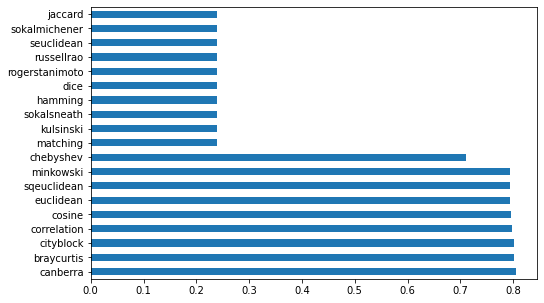

In [ ]:
acc_dist.sort_values(ascending=False).plot(kind='barh',figsize=(8,5))

### Exercise 3: Accelerating K-Nearest Neighbour Classifier

Partial Distances/Lower Bounding

For this task I used K=3 because, even though I am aware I cannot just extrapolate the conclusion, this value proved to be the best one when using euclidean distance for exercise 2.

In [ ]:
# Input: dataframe used as training dataset, instance (row), number for neighbors to take
# Output: numpy array of size K with the indices of the k-nearest neighbors to the instance in the dataframe
#This third version of knns implement partial distances and lower bounding
def knns_v3(df,instance,K): #set of k nearest rows of the dataframe to the instance

  M = len(instance)
  D = np.empty([K,2])
  i = 0
  for index, row in df.iterrows():
    if i <= K: #the first K distances are directly placed into the distance array
      d = ((instance-row)**2).sum()**(1/2) #euclidean distance
      if i < K:
        D[i] = [index,d]
        i += 1
        continue
      else:
        D = D[np.argsort(D[:,1])] #the first K distances are sorted
        DK = D[K-1,1]
        i += 1
    
    d = 0
    m = 0
    while m < M and d < DK**2:
      d += (instance.iloc[m]-row.iloc[m])**2 #distance respect along the specific feature is added
      m += 1
    d = d**(1/2)
    if d < DK: #the new calculated distances are compared only to the last and bigger value of the distance array
      D[K-1] = [index,d]
      D = D[np.argsort(D[:,1])] #when a new distance is added, the array is sorted again
      DK = D[K-1,1]
  C_idxs = D[:,0].astype(int)
  return C_idxs

In [ ]:
# Input: dataframe used as training dataset (df1), dataframe whose class we need to predict (df2), number for neighbors to take
# Output: dataframe with predicted class by k-nearest neighbors
def KNNClassifier_v2(df1,df2,k):
  np.random.seed(3116)
  y_pred = pd.Series(index=df2.index,dtype=float) #class vector
  df1woc = df1.drop(0,axis=1)
  df2woc = df2.drop(0,axis=1)
  for index, row in df2woc.iterrows():
    C_idxs = knns_v3(df1woc,row,k)
    C = df1.loc[C_idxs]
    y_pred.loc[index] = np.random.choice(C[0].mode())
  df2woc[0] = y_pred
  return df2woc

In [ ]:
#Dataset with largest number of samples
l_n_samples = 0
for dfk in dfs_merged.keys():
  n_samples = len(dfs_merged[dfk])
  if n_samples > l_n_samples:
    l_dfk = dfk
    l_n_samples = n_samples
    ts_length = len(dfs_merged[dfk].columns-1)

print('Name',l_dfk,'; Time series length:',ts_length,'; Number of samples:',l_n_samples)

Name Crop ; Time series length: 47 ; Number of samples: 24000


In [ ]:
%%time
#KNN Classification on Crop Times Series dataset
crop_train = dfs_stand['Crop']['TRAIN']
crop_valid = dfs_stand['Crop']['VALID']
crop_valid_pred = KNNClassifier_v2(crop_train,crop_valid,3)
accuracy_df = accuracy(crop_valid,crop_valid_pred)
print('Accuracy',accuracy_df)

Accuracy 0.7483333333333333
CPU times: user 2h 7min 27s, sys: 16.5 s, total: 2h 7min 44s
Wall time: 2h 8min 21s


Locality Sensitive Hashing

LSH refers to a family of indexing techniques (known as LSH families) to hash data points into buckets so that data points near each other are located in the same buckets with high probability, while data points far from each other are likely to be in different buckets. This makes it possible to search efficiently for nearest neighbours amongst large collections of items.

For this exercise, I used the hash function **Random Binary Projection**.

In [ ]:
# Input: dataframe, length of the encoding (J)
# Output: dataframe with the same index but hash codes as values
def hash(df,J,seed=3116):
  np.random.seed(seed)
  X = df.to_numpy(copy=True)
  N,M = df.shape
  R = np.random.rand(M,J) #pool of normal vectors that represent a pool of hyperparameters
  H = np.where(X@R > 0, 1, 0) #instances in X are encode based on their position respect to each of the hyperplanes.
  Hashes = pd.DataFrame(0,index=df.index,columns=['hashes'])
  for _ in range(N): #assigns a hash code to instance in the dataframe 
    Hashes.iloc[_] = ''.join(map(str,H[_]))
  return Hashes

# Input: dataframe, length of the encoding (J)
# Output: dataframe with hash codes as index and the indices as values
def hash_table(df,J,seed=3116):
  Hashes = hash(df,J,seed)
  Htable = {}
  for index, row in Hashes.iterrows():
    h = row.values[0] #hash key
    if h in Htable.keys():
      Htable[h] = Htable[h].append(pd.Index([index]))
    else:
      Htable[h] = pd.Index([index])
  return Htable

In [ ]:
# Input: dataframe used as training dataset (df1), dataframe whose class we need to predict (df2), number for neighbors to take (k)
#        number of hyperplanes (J), number of pools of hyperplanes (L) use to define the sectors
# Output: dataframe with predicted class by k-nearest neighbors with LSH
def KNNClassifier_v3(df1,df2,k,J,L,distype='euclidean'):

  df1woc = df1.drop(0,axis=1)
  df2woc = df2.drop(0,axis=1)

  #Sectorization of the instances
  S = {} #dataframe with df2 index as index and df1 indices as values
  #The indices correspond to instances of df1 in the same sector as instance of df2. These sector are overlapping.
  for _ in range(L): #the training space is sectorized L times in order to increase the probability of adding all the close instances
    seed = np.random.randint(100)
    Htable = hash_table(df1woc,J,seed)
    Hashes = hash(df2woc,J,seed)
    for index, row in Hashes.iterrows():
      hk = row.values[0]
      if hk in Htable: #to check that the hash key exists in Htable
        if index in S.keys():
          S[index] = S[index].union(Htable[hk])
        else:
          S[index] = Htable[hk]
  
  y_pred = pd.Series(index=df2.index,dtype=float) #class vector
  for index, row in df2woc.iterrows():
    C_idxs = knns_v2(df1woc.loc[S[index]],row,k,distype) #the algorithm only calculate the distances of instances that in the same sector
    #Since the size of the sector is smaller than the number of instances of df1, the algorithm is faster
    C = df1.loc[C_idxs]
    y_pred.loc[index] = np.random.choice(C[0].mode())
  df2woc[0] = y_pred
  return df2woc

For this task I used 10 hyperplanes to cut the instance space because with a larger number the hash codes of a few instances of validation data (maybe outliers) did not match any of the hash codes available when using the training data. Because in my implementation a hash code was created if it had at least one training instance. That is, hashes available <= 2^K. A further improvement could assign these instances to a sector ramdomly or based on another measure.

In [ ]:
%%time
#KNN Classification on Crop Times Series dataset using LHS
crop_train = dfs_stand['Crop']['TRAIN']
crop_valid = dfs_stand['Crop']['VALID']
crop_valid_pred = KNNClassifier_v3(crop_train,crop_valid,3,10,5)
accuracy_df = accuracy(crop_valid,crop_valid_pred)
print('Accuracy',accuracy_df)

Accuracy 0.7438888888888889
CPU times: user 59min 19s, sys: 30 s, total: 59min 50s
Wall time: 59min 20s


Conclusion: KNN with Local Sensitive Hash proved to be a faster tool when keeping the accuracy very close to the vanilla (and slower) KNN method. 